In [2]:
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
import matplotlib.pyplot as plt
import random

def load_images(image_folder):
    images = []
    print(f"Processing directory: {image_folder}")
    image_files = [f for f in sorted(os.listdir(image_folder)) if f.endswith(('.jpg', '.jpeg', '.png'))]
    print(f"Number of images found: {len(image_files)}")
    for image_file in image_files:
        image_path = os.path.join(image_folder, image_file)
        image = Image.open(image_path).convert('L')
        image = image.resize((256, 256))  
        image = np.array(image) / 255.0  # Normalize pixel values to [0, 1]
        images.append(image)
    return np.array(images)

def create_dataset(downloaded_images_dir, cleaned_images_dir, condition_dir):
    print("Loading downloaded images...")
    downloaded_images = load_images(downloaded_images_dir)
    
    print("Loading cleaned images...")
    cleaned_images = load_images(cleaned_images_dir)
    
    print("Loading condition images...")
    condition_images = load_images(condition_dir)
    
    X_combined = np.stack((downloaded_images, condition_images), axis=-1)

    X_train, X_test, y_train, y_test = train_test_split(X_combined, cleaned_images, test_size=0.2, random_state=42)
    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=42)
    
    print(f"Training set shape: {X_train.shape}")
    print(f"Validation set shape: {X_val.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    return X_train, X_val, X_test, y_train, y_val, y_test

# Directories
downloaded_images_dir = '../../data/glyph_images'
cleaned_images_dir = '../../data/cleaned_images'
condition_dir = '../../data/condition_image'

# Create dataset
X_train, X_val, X_test, y_train, y_val, y_test = create_dataset(downloaded_images_dir, cleaned_images_dir, condition_dir)

# Reshape data to add channel dimension for target
y_train = np.expand_dims(y_train, axis=-1)
y_val = np.expand_dims(y_val, axis=-1)
y_test = np.expand_dims(y_test, axis=-1)

print(f"Reshaped training set shape: {y_train.shape}")
print(f"Reshaped validation set shape: {y_val.shape}")
print(f"Reshaped test set shape: {y_test.shape}")


2024-08-29 05:28:07.090476: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-29 05:28:07.105650: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-29 05:28:07.110035: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-29 05:28:07.121469: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading downloaded images...
Processing directory: ../../data/glyph_images
Number of images found: 16471
Loading cleaned images...
Processing directory: ../../data/cleaned_images
Number of images found: 16471
Loading condition images...
Processing directory: ../../data/condition_image
Number of images found: 16471
Training set shape: (11858, 256, 256, 2)
Validation set shape: (1318, 256, 256, 2)
Test set shape: (3295, 256, 256, 2)
Reshaped training set shape: (11858, 256, 256, 1)
Reshaped validation set shape: (1318, 256, 256, 1)
Reshaped test set shape: (3295, 256, 256, 1)


In [3]:
def combined_loss(y_true, y_pred):
    bce = BinaryCrossentropy()(y_true, y_pred)
    mse = MeanSquaredError()(y_true, y_pred)
    return bce + 0.01 * mse

def unet_model(input_size=(256, 256, 2)):
    inputs = layers.Input(input_size)
    
    # Encoder
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = layers.MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = layers.MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = layers.MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = layers.MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = layers.Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = layers.Conv2D(512, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv5))
    merge6 = layers.concatenate([conv4, up6], axis=3)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = layers.Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = layers.Conv2D(256, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv6))
    merge7 = layers.concatenate([conv3, up7], axis=3)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = layers.Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = layers.Conv2D(128, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv7))
    merge8 = layers.concatenate([conv2, up8], axis=3)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = layers.Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = layers.Conv2D(64, 2, activation='relu', padding='same')(layers.UpSampling2D(size=(2, 2))(conv8))
    merge9 = layers.concatenate([conv1, up9], axis=3)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = layers.Conv2D(64, 3, activation='relu', padding='same')(conv9)
    conv9 = layers.Conv2D(2, 3, activation='relu', padding='same')(conv9)
    conv9 = layers.Conv2D(1, 1, activation='sigmoid')(conv9)

    model = models.Model(inputs, conv9)
    model.compile(optimizer=Adam(learning_rate=0.0001), loss=combined_loss, metrics=['accuracy'])
    
    return model

# Initialize and train the model
model = unet_model()

print("model created")

model created


2024-08-29 05:29:42.000842: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2021] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14200 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4080, pci bus id: 0000:65:00.0, compute capability: 8.9


In [4]:
history = model.fit(X_train, y_train, epochs=10, batch_size=1, validation_data=(X_val, y_val))

Epoch 1/10


I0000 00:00:1724909410.597710     545 service.cc:146] XLA service 0x73099c025840 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1724909410.597745     545 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4080, Compute Capability 8.9
2024-08-29 05:30:10.723401: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-29 05:30:11.291421: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8906
2024-08-29 05:30:13.337053: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-29 05:30:13.465089: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Al

    7/11858 ━━━━━━━━━━━━━━━━━━━━ 4:11 21ms/step - accuracy: 0.6196 - loss: 0.6955  

I0000 00:00:1724909415.931026     545 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


11857/11858 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.9748 - loss: 0.0530

2024-08-29 05:34:00.534046: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.08GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-29 05:34:00.577849: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 8.14GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-08-29 05:34:00.620625: W external/local_tsl/tsl/framework/bfc_allocator.cc:291] Allocator (GPU_0_bfc) ran out of memory trying to allocate 4.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


11858/11858 ━━━━━━━━━━━━━━━━━━━━ 244s 20ms/step - accuracy: 0.9748 - loss: 0.0530 - val_accuracy: 0.9822 - val_loss: 0.0257
Epoch 2/10
11858/11858 ━━━━━━━━━━━━━━━━━━━━ 231s 19ms/step - accuracy: 0.9841 - loss: 0.0222 - val_accuracy: 0.9840 - val_loss: 0.0185
Epoch 3/10
11858/11858 ━━━━━━━━━━━━━━━━━━━━ 232s 20ms/step - accuracy: 0.9851 - loss: 0.0165 - val_accuracy: 0.9846 - val_loss: 0.0177
Epoch 4/10
11858/11858 ━━━━━━━━━━━━━━━━━━━━ 231s 20ms/step - accuracy: 0.9855 - loss: 0.0149 - val_accuracy: 0.9855 - val_loss: 0.0131
Epoch 5/10
11858/11858 ━━━━━━━━━━━━━━━━━━━━ 230s 19ms/step - accuracy: 0.9859 - loss: 0.0127 - val_accuracy: 0.9854 - val_loss: 0.0126
Epoch 6/10
11858/11858 ━━━━━━━━━━━━━━━━━━━━ 230s 19ms/step - accuracy: 0.9859 - loss: 0.0115 - val_accuracy: 0.9855 - val_loss: 0.0122
Epoch 7/10
11858/11858 ━━━━━━━━━━━━━━━━━━━━ 234s 20ms/step - accuracy: 0.9861 - loss: 0.0106 - val_accuracy: 0.9854 - val_loss: 0.0120
Epoch 8/10
11858/11858 ━━━━━━━━━━━━━━━━━━━━ 233s 20ms/step - accur

103/103 ━━━━━━━━━━━━━━━━━━━━ 30s 188ms/step


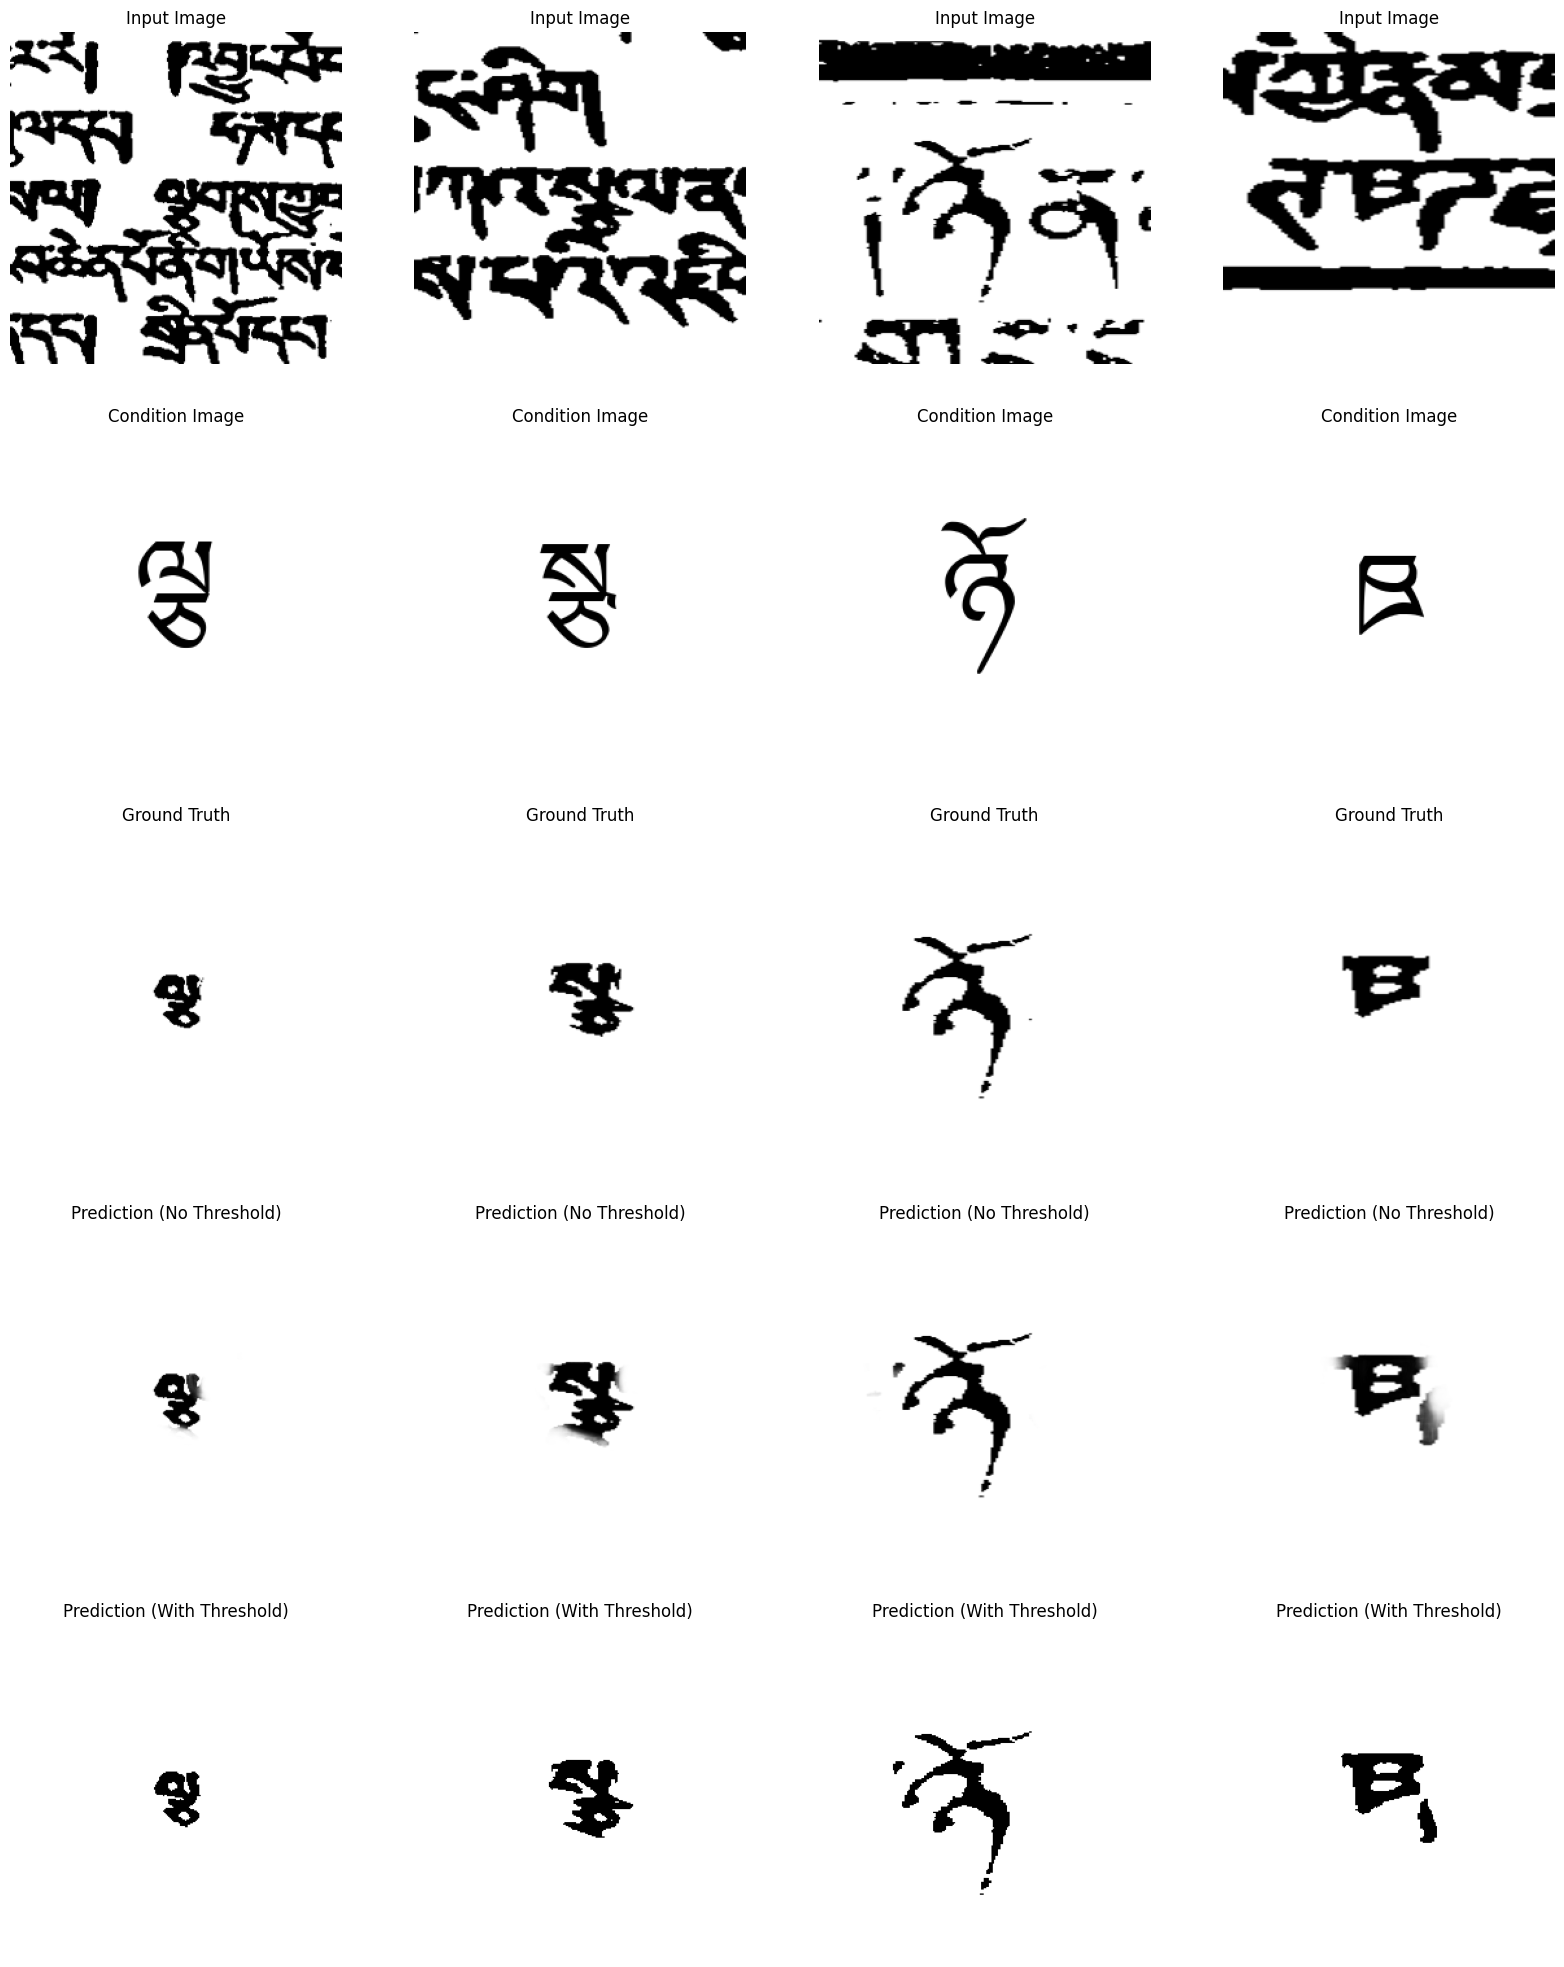

In [5]:
def apply_threshold(image, threshold=0.5):
    return (image > threshold).astype(np.float32)

def display_sample_predictions(model, X_test, y_test):
    predictions = model.predict(X_test)
    n_samples = 4
    plt.figure(figsize=(20, 25))
    for i in range(n_samples):
        idx = random.randint(0, len(X_test) - 1)
        
        plt.subplot(5, n_samples, i + 1)
        plt.title("Input Image")
        plt.imshow(X_test[idx, :, :, 0], cmap='gray')  # Show the dirty image part
        plt.axis('off')
        
        plt.subplot(5, n_samples, i + n_samples + 1)
        plt.title("Condition Image")
        plt.imshow(X_test[idx, :, :, 1], cmap='gray')  # Show the glyph image part
        plt.axis('off')

        plt.subplot(5, n_samples, i + 2 * n_samples + 1)
        plt.title("Ground Truth")
        plt.imshow(y_test[idx].squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(5, n_samples, i + 3 * n_samples + 1)
        plt.title("Prediction (No Threshold)")
        plt.imshow(predictions[idx].squeeze(), cmap='gray')
        plt.axis('off')

        plt.subplot(5, n_samples, i + 4 * n_samples + 1)
        plt.title("Prediction (With Threshold)")
        plt.imshow(apply_threshold(predictions[idx]).squeeze(), cmap='gray')
        plt.axis('off')
    plt.show()

# Display sample predictions
display_sample_predictions(model, X_test, y_test)

In [7]:
# save the model in Keras format
model_save_path = '../../data/model/glyph_cropping_model.keras'
model.save(model_save_path)

print(f"Model saved to {model_save_path}")


Model saved to ../../data/model/glyph_cropping_model.keras


In [3]:
import numpy as np
from PIL import Image
import os
import random
from tensorflow.keras.models import load_model
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError
import tensorflow as tf

# Define combined_loss function
def combined_loss(y_true, y_pred):
    bce = BinaryCrossentropy()(y_true, y_pred)
    mse = MeanSquaredError()(y_true, y_pred)
    return bce + 0.01 * mse

# Load the model with the custom loss function
model_save_path = '../../data/model/glyph_cropping_model.keras'
model = load_model(model_save_path, custom_objects={'combined_loss': combined_loss})

def apply_threshold(image, threshold=0.5):
    return (image > threshold).astype(np.float32)

def prepare_inference_data(downloaded_image_path, condition_image_path):
    downloaded_image = Image.open(downloaded_image_path).convert('L')
    downloaded_image = downloaded_image.resize((256, 256))
    downloaded_image_array = np.array(downloaded_image) / 255.0

    condition_image = Image.open(condition_image_path).convert('L')
    condition_image = condition_image.resize((256, 256))
    condition_image_array = np.array(condition_image) / 255.0

    input_data = np.stack((downloaded_image_array, condition_image_array), axis=-1)
    input_data = np.expand_dims(input_data, axis=0)
    
    return input_data, downloaded_image.size

def run_inference(input_data, threshold=0.5):
    predictions = model.predict(input_data)
    thresholded_predictions = apply_threshold(predictions, threshold)
    return thresholded_predictions

def save_predicted_image(predicted_image, output_path, original_size):
    predicted_image = (predicted_image.squeeze() * 255).astype(np.uint8)
    predicted_image = Image.fromarray(predicted_image)
    predicted_image = predicted_image.resize(original_size, Image.BILINEAR)
    predicted_image.save(output_path)
    print(f"Saved predicted image to {output_path}")

def process_images_in_directory(glyph_image_dir, condition_image_dir, output_dir, threshold=0.5, num_samples=5, random_sampling=True):
    os.makedirs(output_dir, exist_ok=True)

    glyph_image_files = sorted([f for f in os.listdir(glyph_image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])
    condition_image_files = sorted([f for f in os.listdir(condition_image_dir) if f.endswith(('.jpg', '.jpeg', '.png'))])

    if random_sampling:
        selected_glyph_files = random.sample(glyph_image_files, min(num_samples, len(glyph_image_files)))
        selected_condition_files = random.sample(condition_image_files, min(num_samples, len(condition_image_files)))
    else:
        selected_glyph_files = glyph_image_files
        selected_condition_files = condition_image_files

    for glyph_file, condition_file in zip(selected_glyph_files, selected_condition_files):
        glyph_image_path = os.path.join(glyph_image_dir, glyph_file)
        condition_image_path = os.path.join(condition_image_dir, condition_file)

        input_data, original_size = prepare_inference_data(glyph_image_path, condition_image_path)
        predicted_cleaned_image = run_inference(input_data, threshold)
        output_path = os.path.join(output_dir, f"predicted_{glyph_file}")
        save_predicted_image(predicted_cleaned_image, output_path, original_size)

# Input and output directories
glyph_image_dir = '../../data/test_images/derge/derge_glyph_images'
condition_image_dir = '../../data/test_images/derge/derge_condition_images'
output_dir = '../../data/predicted_images/derge'
process_images_in_directory(glyph_image_dir, condition_image_dir, output_dir, threshold=0.5, num_samples=5, random_sampling=True)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 627ms/step
Saved predicted image to ../../data/predicted_images/derge/predicted_derge_འུ_22.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Saved predicted image to ../../data/predicted_images/derge/predicted_derge_ྗ_2.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 335ms/step
Saved predicted image to ../../data/predicted_images/derge/predicted_derge_ཙུ_13.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
Saved predicted image to ../../data/predicted_images/derge/predicted_derge_ནྡྷ_16.png
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 340ms/step
Saved predicted image to ../../data/predicted_images/derge/predicted_derge_ཥཱ_40.png
